Kütüphaneleri Yükleme 

In [5]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

Veriyi okuma 

In [6]:
test_df = pd.read_csv("/kaggle/input/install-future-program-istanbul-hackathon/test.csv")
train_df = pd.read_csv("/kaggle/input/install-future-program-istanbul-hackathon/train.csv")
sample_submission =pd.read_csv("/kaggle/input/install-future-program-istanbul-hackathon/sample_submission.csv")


Veriyi Gözlemleme

In [7]:
train_df.head(10)

,DATETIME,SERVER,CPU,CPULOAD
0,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-0,3.88
1,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-1,11.33
2,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-10,5.31
3,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-11,5.25
4,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-12,0.28
5,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-13,1.99
6,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-14,0.57
7,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-15,0.35
8,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-16,0.64
9,2020-03-24 00:00:00+03:00,CIHAZ_301,CPU-17,0.36


In [8]:
train_df.tail(10)

,DATETIME,SERVER,CPU,CPULOAD
312686,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-21,3.18
312687,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-22,2.97
312688,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-23,3.38
312689,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-3,16.82
312690,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-4,13.39
312691,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-5,16.17
312692,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-6,16.02
312693,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-7,14.14
312694,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-8,15.42
312695,2020-05-30 23:45:00+03:00,CIHAZ_305,CPU-9,13.30


In [39]:
#str veri tipinden datetime tipine dönüştürme 
train_df['DATETIME'] = pd.to_datetime(train_df['DATETIME'], format='%Y-%m-%dT%H:%M')
test_df['DATETIME'] = pd.to_datetime(test_df['DATETIME'], format='%Y-%m-%dT%H:%M')

In [41]:
#serverları ayrı değerlendirmek için df leri ayırma 
server_305 = train_df[train_df["SERVER"]=="CIHAZ_305"]
server_301 = train_df[train_df["SERVER"]=="CIHAZ_301"]

In [45]:
print(f"Mae değeri: {mmm}")

Mae değeri:3


In [46]:
def prophet_pred(cihaz_df,test_s=96,params = None):
    """
    parametre olarak girilen dataframe i train test olarak böler.
    girilen parametrelerle model kurar,  mae ve mape değerlerinin hesaplar ve tahminlenen değerleri dataframe olarak döndürür.
    
    cihaz_df: model kurulacak dataframe 
    test_s  : test veri setinin kaç birim zaman olacağı default = 96(bir gün)
    params  : model parametreleri default None
    
    return y_pred: tahminlenen değerleri döndürür.
    
    """
    #24 cpu için ortalama değerleri alma
    df = cihaz_df.groupby(["DATETIME"]).agg({"CPULOAD":"mean"})
    
    #prophet için zaman değişkenini 'ds' olarak isimlendirme ve index resetleme 
    df.index.names = ["ds"]
    df.reset_index(inplace=True)
    
    #zaman değişkenindeki time zone değerinden kurtulma 
    df['ds'] = df['ds'].dt.tz_localize(None)
    
    #bağımlı değişkeni prophet modeline uygun formata getirme.
    df["y"] = df["CPULOAD"]
    df.drop("CPULOAD",axis = 1, inplace= True)
    print("check1")
    
    #girilen size ile train test ayrımı test veri setindeki bağımlı değişkenlerin silinmesi 
    test = df.iloc[-test_s:]
    test["y"] = np.nan
    train = df.iloc[:-test_s]
    print("check2")
    
    #model parametreleri dışsal olarak verilmişse kullan, verilmemişse default değerler ile model kur
    if params == None:
        m = Prophet()
        m.fit(train)
    else : 
        m = Prophet(**params)
        m.fit(train)
        
    print("check3")
    
    #size e göre tahmin df i oluştur ve tahmin yap
    y_pred = df.iloc[-test_s:]
    y_pred= m.predict(y_pred)

    #tahmin değeri olan yhat' a göre mae ve mape değerlerinin hesaplanması 
    mape = mean_absolute_percentage_error(df.iloc[-test_s:]["y"], y_pred["yhat"])
    mae = mean_absolute_error(df.iloc[-test_s:]["y"], y_pred["yhat"])
    print(f"Mae değeri: {mae}")
    print(f"Mape değeri: {mape}")
    
    #test veri setindeki değerlerin tahmin edilen değerler ile birlikte grafik olarak gösterilmesi 
    plt.figure(figsize=(14,6))
    plt.plot(df.iloc[-test_s:]["ds"], df.iloc[-test_s:]["y"], label='Gerçek Değerler')
    plt.plot(y_pred["ds"], y_pred["yhat"], label='Tahmin edilen')
    plt.xlabel("Tarih")
    plt.ylabel("CPULOAD")
    plt.legend()
    plt.show()
    print("check5")
    
    return y_pred

check1
check2


10:38:43 - cmdstanpy - INFO - Chain [1] start processing
10:38:44 - cmdstanpy - INFO - Chain [1] done processing


check3
Mae değeri: 0.7407353057551239
Mape değeri: 0.14750006704264126


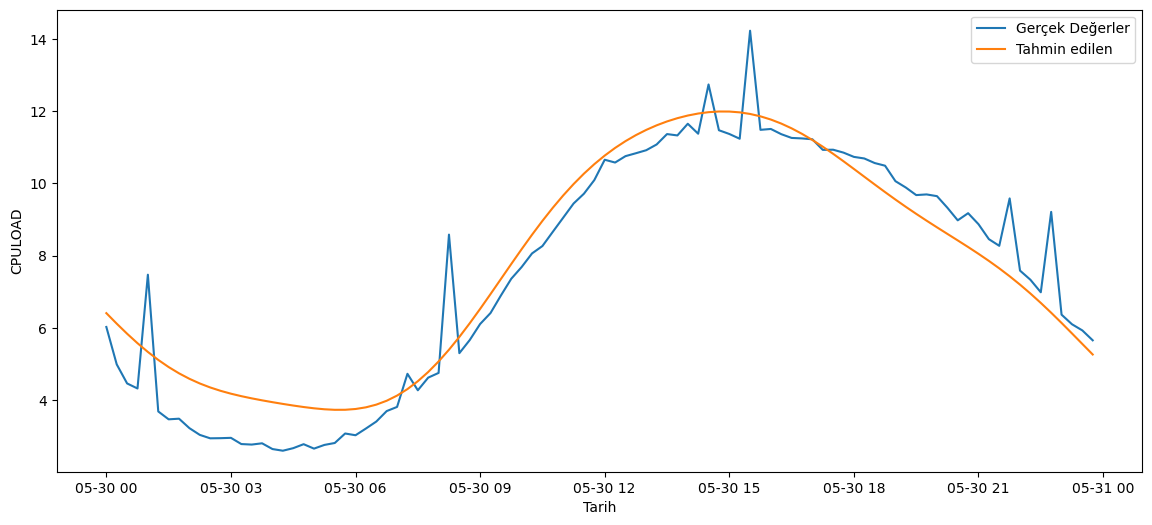

check5


In [47]:
y_pred = prophet_pred(server_301)

check1
check2


10:39:04 - cmdstanpy - INFO - Chain [1] start processing
10:39:05 - cmdstanpy - INFO - Chain [1] done processing


check3
Mae değeri: 1.4541560002845986
Mape değeri: 0.1971731506740985


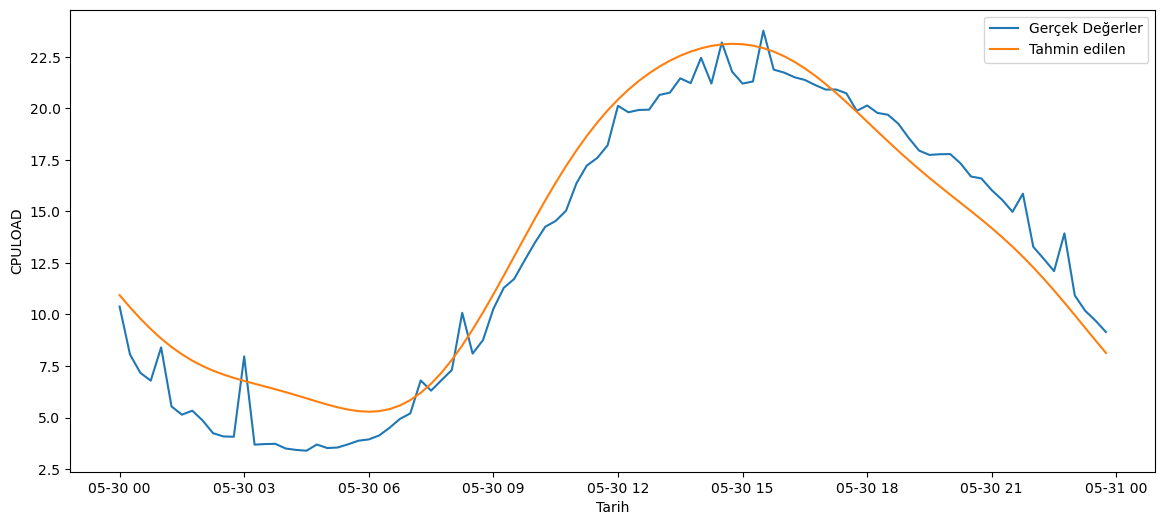

check5


In [48]:
y_pred = prophet_pred(server_305)

In [49]:
#hiperparametre optimizasyonu yaparken aranacak hiperparametre uzayının belirlenmesi 
param_grid = {'growth': ['linear'],
    'seasonality_prior_scale': np.arange(1,20, 2),
    'changepoint_range': np.arange(0.8,1.0,0.1),
     'changepoint_prior_scale': np.arange(0.01,1.0, 0.01)
}


In [54]:
def prophet_tahmin_opt(cihaz_df,test_s=96,params=None):
    
    """
    parametre olarak girilen dataframe i train test olarak böler.
    girilen parametrelerle model kurar,  mae ve mape değerlerinin hesaplar ve mae değerini döndürür. 
    opt yapmak için kurgulanmıştır 
    
    cihaz_df: model kurulacak dataframe 
    test_s  : test veri setinin kaç birim zaman olacağı default = 96(bir gün)
    params  : model parametreleri default None
    
    return mae: hesaplanan mae değerini döndürür değerleri döndürür.
    
    """
    
    df = cihaz_df.groupby(["DATETIME"]).agg({"CPULOAD":"mean"})
    df.index.names = ["ds"]
    df.reset_index(inplace=True)
    df['ds'] = df['ds'].dt.tz_localize(None)
    df["y"] = df["CPULOAD"]
    df.drop("CPULOAD",axis = 1, inplace= True)

    test = df.iloc[-test_s:]
    test["y"] = np.nan
    train = df.iloc[:-test_s]

    m = Prophet(**params)
    m.fit(train)

    y_pred = df.iloc[-test_s:]
    y_pred= m.predict(y_pred)

    mae = mean_absolute_error(df.iloc[-test_s:]["y"], y_pred["yhat"])
    print(f"Denen Parametreler: {params}")
    print(f"mae değeri: {mae}")
    
    return mae 

In [ ]:
#döngü içinde bulunacak en iyi parametreler ve mae değerleri için değişken oluşturma
best_params = None
best_score = float('inf')

In [52]:
#belirlenen parametre uzayında modelin tekrarlı bir şekilde kurulması, mae değerine göre en iyi parametre kombinasyonunun seçilmesi 

for params in tqdm(ParameterGrid(param_grid)):
    mae = prophet_tahmin_opt(server_301,params=params)
    if mae < best_score :
        best_params = params
        best_score = mae


'for params in tqdm(ParameterGrid(param_grid)):\n    mae = prophet_tahmin_opt(server_301,params=params)\n    if mae < best_score :\n        best_params = params\n        best_score = mae\n    '

In [20]:
best_params

{'changepoint_prior_scale': 0.01,
 'changepoint_range': 0.8,
 'growth': 'linear',
 'seasonality_prior_scale': 3}

In [21]:
#notebook kaydolurken yukardaki döngüyü çalıştırmak uzun süreceği için daha önce gelen sonuçlar best params olarak kaydedilmiştir. 
best_params = {'changepoint_prior_scale': 0.060000000000000005,
 'changepoint_range': 0.9,
 'growth': 'linear',
 'seasonality_prior_scale': 7}

In [22]:
best_score

0.7721663875210556

check1
check2


09:51:23 - cmdstanpy - INFO - Chain [1] start processing
09:51:25 - cmdstanpy - INFO - Chain [1] done processing


check3
check4
0.7263324272497641


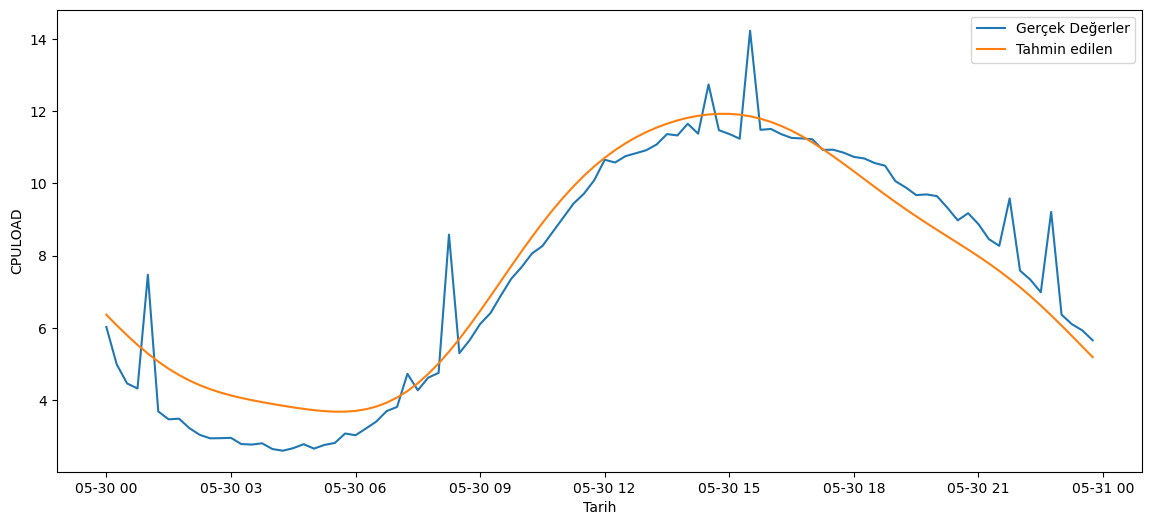

check5


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-05-30 00:00:00,8.352490,4.645420,8.121209,8.352490,8.352490,-1.987470,-1.987470,-1.987470,-2.093383,-2.093383,-2.093383,0.105914,0.105914,0.105914,0.0,0.0,0.0,6.365020
1,2020-05-30 00:15:00,8.352676,4.275330,7.748999,8.352676,8.352676,-2.279636,-2.279636,-2.279636,-2.369120,-2.369120,-2.369120,0.089484,0.089484,0.089484,0.0,0.0,0.0,6.073040
2,2020-05-30 00:30:00,8.352862,3.952983,7.468506,8.352862,8.352862,-2.558919,-2.558919,-2.558919,-2.631741,-2.631741,-2.631741,0.072822,0.072822,0.072822,0.0,0.0,0.0,5.793943
3,2020-05-30 00:45:00,8.353048,3.815732,7.204248,8.353048,8.353048,-2.821635,-2.821635,-2.821635,-2.877569,-2.877569,-2.877569,0.055933,0.055933,0.055933,0.0,0.0,0.0,5.531413
4,2020-05-30 01:00:00,8.353234,3.657286,7.155529,8.353234,8.353234,-3.064752,-3.064752,-3.064752,-3.103577,-3.103577,-3.103577,0.038825,0.038825,0.038825,0.0,0.0,0.0,5.288483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,2020-05-30 22:45:00,8.369431,4.546190,8.166392,8.363637,8.375751,-2.021713,-2.021713,-2.021713,-0.665758,-0.665758,-0.665758,-1.355955,-1.355955,-1.355955,0.0,0.0,0.0,6.347718
92,2020-05-30 23:00:00,8.369617,4.347311,7.810481,8.363620,8.376102,-2.304445,-2.304445,-2.304445,-0.943993,-0.943993,-0.943993,-1.360452,-1.360452,-1.360452,0.0,0.0,0.0,6.065172
93,2020-05-30 23:15:00,8.369803,3.999665,7.455701,8.363659,8.376453,-2.594256,-2.594256,-2.594256,-1.229734,-1.229734,-1.229734,-1.364522,-1.364522,-1.364522,0.0,0.0,0.0,5.775548
94,2020-05-30 23:30:00,8.369989,3.734277,7.234570,8.363744,8.376957,-2.887491,-2.887491,-2.887491,-1.519330,-1.519330,-1.519330,-1.368162,-1.368162,-1.368162,0.0,0.0,0.0,5.482498


In [23]:
#best params ile tekrar test grafiğin gözlemlenmesi ve değerlendirme metriklerinin hespaplanması
prophet_pred(server_301,params = best_params)

In [26]:
def prophet_final(cihaz_df,cihaz_isim,test_df,params):
    """
    parametre olarak girilen df in tamamını eğitim seti olarak değerlendirir. 
    model kurulum ve tahminleme aşamasının ardından submission dosyasında istenen formata uygun hale getirmek üzere 
    tahmin değerlerini döndürür.
    
    cihaz_df: model kurulmak istenen dataframe:
    cihaz_isim: submission dosyaında index ayarları yapabilmek için hangi cihazın modele sokulduğu bilgisini içeren parametre.
    test_df: tahminlerin tutulacağı test dataframe i 
    params: modelin kurulacağı parametre kombinasyonu. 
    
    """
    
    print("check1")
    df = cihaz_df.groupby(["DATETIME"]).agg({"CPULOAD":"mean"})
    df.index.names = ["ds"]
    df.reset_index(inplace=True)
    df['ds'] = df['ds'].dt.tz_localize(None)
    df["y"] = df["CPULOAD"]
    df.drop("CPULOAD",axis = 1, inplace= True)
    print("check1")

    m = Prophet(**params)
    m.fit(df)
    print("check3")

    if cihaz_isim == "301":
        test_cihaz = test_df[test_df["index"]%2 == 0]
    elif cihaz_isim == "305":
        test_cihaz = test_df[test_df["index"]%2 != 0]
    print("check4")
        
    test_cihaz = test_cihaz.rename(columns={'DATETIME': 'ds', 'SERVER': 'y'})
    test_cihaz['ds'] = test_cihaz['ds'].dt.tz_localize(None)
    test_cihaz.drop("index",axis = 1 , inplace=True)
    test_cihaz["y"] = np.nan
    print("check5")
    
    forecast = m.predict(test_cihaz)
    print("check6")
    
    return forecast

In [29]:
#tahminlerin değişkenlere atanması 
cihaz_301_pred = prophet_final(server_301,cihaz_isim="301",test_df = test_df, params = best_params)
cihaz_305_pred = prophet_final(server_305,cihaz_isim="305",test_df = test_df, params = best_params)

check1
check1


09:54:02 - cmdstanpy - INFO - Chain [1] start processing
09:54:03 - cmdstanpy - INFO - Chain [1] done processing


check3
check4
check5
check6
check1
check1


09:54:04 - cmdstanpy - INFO - Chain [1] start processing
09:54:05 - cmdstanpy - INFO - Chain [1] done processing


check3
check4
check5
check6


In [30]:
#datetime modülünün dönüşümü
test_df["DATETIME"] = test_df["DATETIME"].dt.tz_localize(None)

In [31]:
#submission dosyasına uygun hale getirmek için cihazların index bilgilerinin ayarlanması 
cihaz_301_pred["index"] = np.arange(1,192,2)
cihaz_305_pred["index"] = np.arange(0,192,2)

In [ ]:
#tahmin sonuçlarının birleştirilmesi 
submission = pd.concat([cihaz_301_pred[["ds","yhat","index"]],cihaz_305_pred[["ds","yhat","index"]]],axis=0).sort_values("index")

In [33]:
#submission df i görüntüleme 
submission

,ds,yhat,index
0,2020-05-31 00:00:00,7.054952,0
0,2020-05-31 00:00:00,4.905160,1
1,2020-05-31 00:15:00,6.496341,2
1,2020-05-31 00:15:00,4.625297,3
2,2020-05-31 00:30:00,5.975730,4
...,...,...,...
93,2020-05-31 23:15:00,6.858848,187
94,2020-05-31 23:30:00,10.673609,188
94,2020-05-31 23:30:00,6.582404,189
95,2020-05-31 23:45:00,10.105635,190


In [34]:
#tarih değişkenini silme
submission.drop("ds",axis=1, inplace=True)

In [35]:
#istenen formata uygun hale getirme 
submission.reset_index(drop=True,inplace=True)
submission = submission.rename(columns={"yhat":"CPULOAD"})
sütun_sırası = ['index', 'CPULOAD']  # Yeni sütun sırası listesi
submission = submission.reindex(columns=sütun_sırası)


In [36]:
submission

,index,CPULOAD
0,0,7.054952
1,1,4.905160
2,2,6.496341
3,3,4.625297
4,4,5.975730
...,...,...
187,187,6.858848
188,188,10.673609
189,189,6.582404
190,190,10.105635


In [37]:
sample_submission["CPULOAD"] = submission["CPULOAD"]

In [38]:
sample_submission.to_csv('sample_submission.csv',index=False)